# [06] 이미지 분류하기 실습 가위바위보

텐서플로우의 케라스를 활용해서 이미지 분류 실습을 진행한다.
> tf.keras

## 딥러닝 프레임워크인 텐서플로우를 이용한 이미지 분류기 만들기

0. 인공지능 모델실습 개요
- 사진에서 가위, 바위, 보를 인식하고 분류해서 컴퓨터가 인식이 가능하도록 별도의 클래스에 넣어준다.
- 텐서플로우의 케라스 프레임워크를 활용해서 CNN 딥러닝 모델을 실습한다.
- validation dataset을 만들어 보자.
- 모델 정확도를 60% 이상 나오도록 해보자.

1. 데이터셋 확인하기

2. EDA
- 이미지 사이즈 및 색상확인

3. 전처리 및 feature 엔지니어링
- MNIST 손글씨 문제처럼 28*28 크기로 축소하자.

4. 모델 만들기
- CNN 모델로 만들기

5. 모델 학습 및 예측

6. 모델 평가
- 반복회수(에포크)에 따라 정확도와 손실값을 시각화해보자.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

from PIL import Image
import glob


TensorFlow version: 2.10.0
Num GPUs Available:  1


## 1. 데이터셋 확인하기

(224, 224, 3)


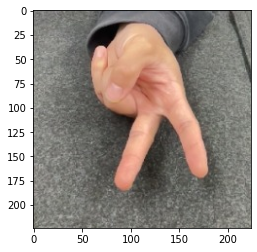

In [20]:
images = []
for img_path in glob.glob(os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/scissor/*.jpg"):
    images.append(mpimg.imread(img_path))

plt.imshow(images[0])
print(images[0].shape)

트레인 데이터를 확인해보니, 이미지 3컬러 이미지로 224 너비와 224 높이를 갖는다.

먼저, MNIST 손글씨데이터 분석과 같이 28*28사이즈로 조절해보자.

## 가위 이미지 축소 리사이징

In [21]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")


1000  images to be resized.
1000  images resized.
가위 이미지 resize 완료!


## 바위 이미지 축소 리사이징

In [15]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

1000  images to be resized.
1000  images resized.
바위 이미지 resize 완료!


## 보 이미지 축소 리사이징

In [16]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

1000  images to be resized.
1000  images resized.
보 이미지 resize 완료!


In [17]:
import numpy as np

def load_data(img_path, number_of_data=3000):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/"
(x_train, y_train)=load_data(image_dir_path)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_train shape: {}".format(x_val.shape))
print("y_train shape: {}".format(y_val.shape))

학습데이터(x_train)의 이미지 개수는 3000 입니다.
x_train shape: (2400, 28, 28, 3)
y_train shape: (2400,)
y_train shape: (600, 28, 28, 3)
y_train shape: (600,)


In [18]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [19]:
# 가위 테스트
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

# 바위 테스트
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

#보 테스트
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test"
(x_test, y_test) =load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
y_test_norm = y_test/255.0

print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

548  images to be resized.
548  images resized.
가위 이미지 resize 완료!
591  images to be resized.
591  images resized.
바위 이미지 resize 완료!
568  images to be resized.
568  images resized.
보 이미지 resize 완료!
학습데이터(x_train)의 이미지 개수는 1707 입니다.
x_train shape: (3000, 28, 28, 3)
y_train shape: (3000,)


In [20]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=1, validation_data=(x_val, y_val))

Epoch 1/10
   1/2400 [..............................] - ETA: 13:43 - loss: 3.1978e-05 - accuracy: 1.0000

2022-10-07 14:13:54.825998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2397/2400 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.9645

2022-10-07 14:14:11.935837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 20s 8ms/step - loss: 0.2431 - accuracy: 0.9646 - val_loss: 3.0985e-04 - val_accuracy: 1.0000
Epoch 2/10
2400/2400 [==============================] - 18s 7ms/step - loss: 0.1239 - accuracy: 0.9871 - val_loss: 1.4910e-05 - val_accuracy: 1.0000
Epoch 3/10
2400/2400 [==============================] - 19s 8ms/step - loss: 1.7674e-05 - accuracy: 1.0000 - val_loss: 1.0023e-05 - val_accuracy: 1.0000
Epoch 4/10
2400/2400 [==============================] - 19s 8ms/step - loss: 5.8757e-06 - accuracy: 1.0000 - val_loss: 4.2107e-06 - val_accuracy: 1.0000
Epoch 5/10
2400/2400 [==============================] - 18s 8ms/step - loss: 2.5703e-06 - accuracy: 1.0000 - val_loss: 1.5799e-06 - val_accuracy: 1.0000
Epoch 6/10
2400/2400 [==============================] - 17s 7ms/step - loss: 9.5448e-07 - accuracy: 1.0000 - val_loss: 8.7890e-07 - val_accuracy: 1.0000
Epoch 7/10
2400/2400 [==============================] - 17s 7ms/step - loss: 2.7457e-07 - accuracy: 1

In [21]:
# 모델 시험
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f"train_loss: {train_loss} ")
print(f"train_accuracy: {train_accuracy}")
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

2022-10-07 14:16:54.680472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 - 1s - loss: 3.8216e-09 - accuracy: 1.0000 - 551ms/epoch - 7ms/step
94/94 - 0s - loss: 3.2025 - accuracy: 0.2330 - 497ms/epoch - 5ms/step
train_loss: 3.821618577148911e-09 
train_accuracy: 1.0
test_loss: 3.202535390853882 
test_accuracy: 0.2329999953508377


In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

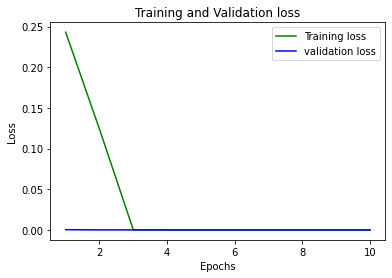

In [23]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,n_train_epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

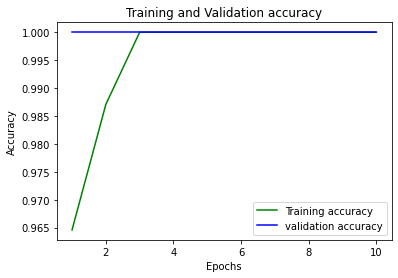

In [24]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 오버피팅을 잡아보자.

에포크 2가 넘어가면서 이미 정확도가 100%가 되었다. 하지만 테스트셋에 대한 정확도는 매우 20%대가 나온다. 이는 1/3도 안되는 값이다. 형편없는 모델학습결과이다.

그러면 다른 데이터셋 하나를 학습용 데이터셋에 추가시켜보자.

In [49]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/new_train/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/new_train/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/new_train/scissor"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

2000  images to be resized.
2000  images resized.
보 이미지 resize 완료!
1595  images to be resized.
1595  images resized.
바위 이미지 resize 완료!
1590  images to be resized.
1590  images resized.
보 이미지 resize 완료!


In [50]:
import numpy as np

def load_data(img_path, number_of_data=5595):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/new_train/"
(x_train, y_train)=load_data(image_dir_path)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_train shape: {}".format(x_val.shape))
print("y_train shape: {}".format(y_val.shape))

학습데이터(x_train)의 이미지 개수는 5185 입니다.
x_train shape: (4476, 28, 28, 3)
y_train shape: (4476,)
y_train shape: (1119, 28, 28, 3)
y_train shape: (1119,)


In [51]:
# 바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 32)               

In [52]:
# 가위 테스트
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

# 바위 테스트
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

#보 테스트
image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/Workspace/project/projects/aiffel/exploration/data/rsp_game/test"
(x_test, y_test) =load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
y_test_norm = y_test/255.0

print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

548  images to be resized.
548  images resized.
가위 이미지 resize 완료!
591  images to be resized.
591  images resized.
바위 이미지 resize 완료!
568  images to be resized.
568  images resized.
보 이미지 resize 완료!
학습데이터(x_train)의 이미지 개수는 1707 입니다.
x_train shape: (5595, 28, 28, 3)
y_train shape: (5595,)


In [53]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=1, validation_data=(x_val, y_val))

Epoch 1/10
   1/4476 [..............................] - ETA: 1:04:54 - loss: 73.1952 - accuracy: 0.0000e+00

2022-10-07 15:06:54.736139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4475/4476 [============================>.] - ETA: 0s - loss: 0.3313 - accuracy: 0.9276

2022-10-07 15:07:24.817977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4476/4476 [==============================] - 35s 8ms/step - loss: 0.3312 - accuracy: 0.9276 - val_loss: 0.0585 - val_accuracy: 0.9839
Epoch 2/10
4476/4476 [==============================] - 34s 8ms/step - loss: 0.1098 - accuracy: 0.9696 - val_loss: 0.0641 - val_accuracy: 0.9786
Epoch 3/10
4476/4476 [==============================] - 34s 8ms/step - loss: 0.0787 - accuracy: 0.9815 - val_loss: 0.1304 - val_accuracy: 0.9589
Epoch 4/10
4476/4476 [==============================] - 32s 7ms/step - loss: 0.0854 - accuracy: 0.9821 - val_loss: 0.0142 - val_accuracy: 0.9946
Epoch 5/10
4476/4476 [==============================] - 33s 7ms/step - loss: 0.1389 - accuracy: 0.9861 - val_loss: 0.0435 - val_accuracy: 0.9893
Epoch 6/10
4476/4476 [==============================] - 35s 8ms/step - loss: 0.0531 - accuracy: 0.9868 - val_loss: 0.0266 - val_accuracy: 0.9946
Epoch 7/10
4476/4476 [==============================] - 35s 8ms/step - loss: 0.0355 - accuracy: 0.9911 - val_loss: 0.0086 - val_accuracy: 0.9

In [54]:
# 모델 시험
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f"train_loss: {train_loss} ")
print(f"train_accuracy: {train_accuracy}")
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

2022-10-07 15:12:36.939007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


140/140 - 1s - loss: 0.0028 - accuracy: 0.9993 - 1s/epoch - 8ms/step
175/175 - 1s - loss: 3.9224 - accuracy: 0.7846 - 967ms/epoch - 6ms/step
train_loss: 0.002831551944836974 
train_accuracy: 0.9993297457695007
test_loss: 3.9224374294281006 
test_accuracy: 0.7846291661262512


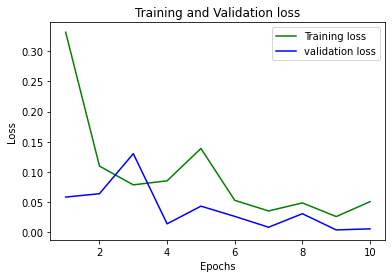

In [55]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,n_train_epoch+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

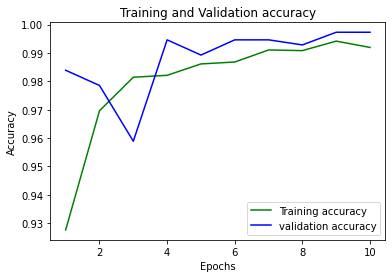

In [56]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 회고

이미지 분류기 모델을 위해서 텐서플로우 케라스 프레임워크를 활용해봤다.
분류기 목표성능인 60%를 달성하긴 했지만, 안정성이 떨어졌다. 실행에 따라서 20%대가 나오기도 하고, 60%가 나오기도 했다.

## 오버피팅
정확도는 반복시행 2회차에서 부터 100%가 나왔다. 하지만 테스트의 정확도가 20~70%까지 시행에 따라 다르게 결과가 나온다. 우선 이렇게 정확도의 차이가 크다는건 관대하게 해석해도 절반인 45%의 정확도라고 볼 수 있는데 매우 낮은 값이다. 그 이유가 오버피팅인거 같다. 트레인 데이터에 넣어준 이미지는 배경이 검은색이라 분류기 목적인 손의 모양과 색상의 대비가 뚜렷하다. 하지만, 테스트 데이터 이미지는 배경, 손모양, 크기 모두 다르다. 

## 오버피팅 해결
다른 학생들이 촬영한 데이터들도 트레인 데이터셋에 넣어주었다. 그러니 훈련에서 정확도가 1이 되지 못했다. 하지만, 점점 우상향 하게 되었다. 결과적으로도 테스트의 정확도 값은 더 잘 나오게 되었다.